<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/GoogleColab/ICNPG_MultiplicacionMatrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiplicación de Matrices en CUDA

El siguiente código compara performances de multiplicación de dos matrices

$$C_{ij}=\sum_{k=1}^N A_{ik} B_{kj}$$

usando algoritmos simples en CPU y GPU, y llamadas a rutinas de cuBLAS.  

In [ ]:
#@title a veces hace falta correr esto al empezar...
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!nvidia-smi

Mon Apr 24 01:24:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Cronómetro para CPU

%%writefile cpu_timer.h

#include <ctime>
#include <iostream>

// estructuras para el timer en CPU ////////////////////

struct timespec diff(timespec start, timespec end)
{
        timespec temp;
       	if ((end.tv_nsec-start.tv_nsec)<0) {
                temp.tv_sec = end.tv_sec-start.tv_sec-1;
                temp.tv_nsec = 1000000000+end.tv_nsec-start.tv_nsec;
        } else {
                temp.tv_sec = end.tv_sec-start.tv_sec;
                temp.tv_nsec = end.tv_nsec-start.tv_nsec;
        }
        return temp;
}
struct cpu_timer{
        struct timespec time1, time2;
	      double ms_elapsed;

        cpu_timer(){
        	tic();
        }
       ~cpu_timer(){}

        void tic(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time1);
        }
        double tac(){
                clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &time2);
                return(ms_elapsed=elapsed());
        }
        double elapsed(){
            return (double)diff(time1,time2).tv_sec*1000 + (double)diff(time1,time2).tv_nsec*0.000001;
        }
};


Writing cpu_timer.h


In [ ]:
#@title multiplicación de matrices usando 5 métodos

%%writefile MatMul.cu

#include<stdio.h>
#include <cuda_runtime.h>
#include "cpu_timer.h"
#include<cublas_v2.h>
#include<cublasXt.h>
#include <fstream>

// dimension de la matriz por default
#define DIM	1024

// si prefiere trabajar con indices de fila y columna 
// estos macros son utiles:

// C[IDX2C(i,j,M)] == valor en fila i (=0,...,Width-1) columna (j=0,1,...Height-1), row-major-C
#define  IDX2C(i,j,ld) (((j)*(ld))+( i )) 

// C[IDX2F(i,j,M)] == valor en fila i (=1,...,Width) columna (j=1,...Height), column-major-F
#define IDX2F(i,j,ld) ((((j)-1)*(ld))+((i)-1)) 


// Matrices are stored in row-major order:
// M(row, col) = *(M.elements + row * M.width + col)
// Matrices are stored in column-major order:
// M(row, col) = *(M.elements + col * M.width + row)
typedef struct {
    int width;
    int height;
    float* elements;
} Matrix;

// Thread block size
#define BLOCK_SIZE 16



////////////////////////////////////////////////////////////////////////
// Forward declaration of the matrix multiplication kernel
__global__ void MatMulKernel(const Matrix, const Matrix, Matrix);
__global__ void MatmulKernelshared(const Matrix, const Matrix, Matrix);

// Matrix multiplication - Host code
// Matrix dimensions are assumed to be multiples of BLOCK_SIZE
void MatMul(const Matrix A, const Matrix B, Matrix C, int caso)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    cudaMemcpy(d_A.elements, A.elements, size,
               cudaMemcpyHostToDevice);
    Matrix d_B;
    d_B.width = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    cudaMemcpy(d_B.elements, B.elements, size,
               cudaMemcpyHostToDevice);

    // Allocate C in device memory
    Matrix d_C;
    d_C.width = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);

    // Invoke kernel
    dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE);
    dim3 dimGrid(B.width / dimBlock.x, A.height / dimBlock.y);

		if(caso==0)
    MatMulKernel<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);
		else 
    MatmulKernelshared<<<dimGrid, dimBlock>>>(d_A, d_B, d_C);

    // Read C from device memory
    cudaMemcpy(C.elements, d_C.elements, size,
               cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}


// Matrix multiplication kernel using global memory called by MatMul()
__global__ void MatMulKernel(Matrix A, Matrix B, Matrix C)
{
    // Each thread computes one element of C
    // by accumulating results into Cvalue
    float Cvalue = 0;
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // En "C-row-major" order seria 
    /*for (int e = 0; e < A.width; ++e)
        Cvalue += A.elements[row * A.width + e]
                * B.elements[e * B.width + col];
    C.elements[row * C.width + col] = Cvalue;
    */	

    // "column-major" order
    for (int e = 0; e < A.width; ++e)
    	Cvalue += A.elements[row + e*A.height]
        * B.elements[e + col * B.height];

    C.elements[row + col * C.height] = Cvalue;
}

// Matrix multiplication kernel using shared and global memory called by MatMul()
__global__ void MatmulKernelshared(Matrix dA, Matrix dB, Matrix dC) {

	  float *A=dA.elements;
	  float *B=dB.elements;
	  float *C=dC.elements;
		int n=dA.width;

    // Declare shared memory arrays for input matrices A and B
    __shared__ float As[BLOCK_SIZE][BLOCK_SIZE];
    __shared__ float Bs[BLOCK_SIZE][BLOCK_SIZE];

    // Compute thread and block indices
    int bx = blockIdx.x;
    int by = blockIdx.y;
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    // Compute row and column indices of output matrix C
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;

    // Initialize the output element to 0
    float Csub = 0.0;

    // Loop over input matrices in blocks of size BLOCK_SIZE
    for (int i = 0; i < n / BLOCK_SIZE; i++) {
        // Load block of input matrix A into shared memory
        As[ty][tx] = A[row * n + i * BLOCK_SIZE + tx];
        // Load block of input matrix B into shared memory
        Bs[ty][tx] = B[(i * BLOCK_SIZE + ty) * n + col];
        // Synchronize threads to ensure all shared memory loads have completed
        __syncthreads();

        // Compute dot product of the corresponding row of A and column of B
        for (int j = 0; j < BLOCK_SIZE; j++) {
            Csub += As[ty][j] * Bs[j][tx];
        }
        // Synchronize threads to ensure all shared memory stores have completed
        __syncthreads();
    }

    // Write the output element to global memory
    C[row * n + col] = Csub;
}




// Matrix multiplication in cpu (column-major)
void MatMulcpu(Matrix A, Matrix B, Matrix C)
{
    for(int row=0; row<A.width;row++){
    	for(int col=0; col<A.height;col++){
    		float Cvalue = 0;
    		for (int e = 0; e < A.width; ++e)
        		Cvalue += A.elements[row + e*A.height]
                	* B.elements[e + col * B.height];

    		C.elements[col + row* C.width] = Cvalue;
    	}
    }
}



////////////////////////////////////////////////////////////////////////
// cublasXt API:
// como cublas, pero recibe matrices input y output del HOST
// se encarga de todas las alocaciones en device copias HD y DH 
void MatMulCublasXt(const Matrix A, const Matrix B, Matrix C)
{
	float  al=1.0f;                 
	float bet =0.0f;
	int m=C.width;

	cublasXtHandle_t manija;
	cublasXtCreate(&manija);

	int devices[1] = { 0 }; 
	cublasXtDeviceSelect(manija, 1, devices);

	cublasXtSgemm(manija,CUBLAS_OP_N,CUBLAS_OP_N,m,m,m,&al,A.elements,m,B.elements,m,&bet,C.elements,m);

	cublasXtDestroy(manija);
}



////////////////////////////////////////////////////////////////////////
// cublas API:
// como cublas, pero recibe matrices input y output del DEVICE
// nos tenemos que encargar de todas las alocaciones en device y copias HD y DH 
void MatMulCublas(const Matrix A, const Matrix B, Matrix C)
{
    // Load A and B to device memory
    Matrix d_A;
    d_A.width = A.width; d_A.height = A.height;
    size_t size = A.width * A.height * sizeof(float);
    cudaMalloc(&d_A.elements, size);
    //cudaMemcpy(d_A.elements, A.elements, size, cudaMemcpyHostToDevice);

    Matrix d_B;
    d_B.width = B.width; d_B.height = B.height;
    size = B.width * B.height * sizeof(float);
    cudaMalloc(&d_B.elements, size);
    //cudaMemcpy(d_B.elements, B.elements, size, cudaMemcpyHostToDevice);

    // Allocate C in device memory
    Matrix d_C;
    d_C.width = C.width; d_C.height = C.height;
    size = C.width * C.height * sizeof(float);
    cudaMalloc(&d_C.elements, size);

	// buena costumbre: hacer algo con los codigos de error
    	cublasStatus_t stat;

	float  al=1.0f;                 
	float bet =0.0f;
	int m=C.width;

	cublasHandle_t manija;
	stat=cublasCreate(&manija);

	// Esto:
    	//cudaMemcpy(A.elements, d_A.elements, size,cudaMemcpyDeviceToHost);
	//cudaMemcpy(B.elements, d_B.elements, size,cudaMemcpyDeviceToHost);
	//cudaMemcpy(C.elements, d_C.elements, size,cudaMemcpyDeviceToHost);
	// Es equivalente a esto:
	stat = cublasSetMatrix(m,m,sizeof(float),(A.elements),m,(d_A.elements) ,m);//a -> d_a
	stat = cublasSetMatrix(m,m,sizeof(float),(B.elements),m,(d_B.elements) ,m);//b -> d_b
	stat = cublasSetMatrix(m,m,sizeof(float),(C.elements),m,(d_C.elements) ,m);//c -> d_c

	// multiplication
	stat=cublasSgemm(manija,CUBLAS_OP_N,CUBLAS_OP_N,m,m,m,&al, d_A.elements,m,d_B.elements,m, &bet, d_C.elements,m);

	// La variable stat se puede usar asi (recomendado para todas las llamadas...)
	if (stat != CUBLAS_STATUS_SUCCESS)
    	{
        	fprintf(stderr, "!!!! CUBLAS Sgemm error\n");
        	exit(1);
    	}

    	// Hacer esto:
    	//cudaMemcpy(C.elements, d_C.elements, size,cudaMemcpyDeviceToHost);
	// es equivalente a esto:
	stat=cublasGetMatrix(m,m,sizeof(float),(d_C.elements) ,m,(C.elements),m);	//d_c->c

    // Free device memory
    cublasDestroy(manija); // liberamos las "variables ocultas" de cublas
    cudaFree(d_A.elements);
    cudaFree(d_B.elements);
    cudaFree(d_C.elements);
}

// activamos todas las APIs

/*#define SIMPLECPU
#define SIMPLECUDA
#define CUBLAS
#define CUBLASXt
*/

////////////////////////////////////////////////////////////////////////
// imprime matrix C ordenada a lo "fortran", column-major 
void print_matrix(Matrix C,std::ofstream &fout){
	// para evitar imprimir demasiado, imprimimos sub-matriz de max x max
	int max=128;
	int maxheight=(C.height>max)?(max):(C.height);
	int maxwidth=(C.width>max)?(max):(C.width);

	int row,col;
	for(row=0;row<maxheight;row++)
	{
		for(col=0;col<maxwidth-1;col++)
		{
			fout << C.elements[row*C.width+col] << " ";
		}
		fout << C.elements[row*C.width+col] << "\n";
	}
}


////////////////////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
	// Usaremos, por simplicidad, matrices cuadradas de NxN
	// N viene del primer argumento de la linea de comandos, sino se fija a DIM=1024 
	int N;
	if(argc>1){
		N=atoi(argv[1]);
	}else N=DIM;

	// matrices para hacer C=A*B	
        Matrix A, B, C;

	// inicializacion de las dimensiones de las matrices (cuadradas por simplicidad)
	A.width=B.width=C.width=A.height=B.height=C.height=N; 
	
    	size_t size = A.width * A.height * sizeof(float);

	// alocacion de matrices en el HOST
	A.elements=(float *)malloc(size);
	B.elements=(float *)malloc(size);
	C.elements=(float *)malloc(size);

	// inicializacion de matrices en el HOST
	for(int i=0;i<A.width*A.height;i++)
	{
		// matriz aleatoria
		A.elements[i]=rand()*1.f/RAND_MAX;
		//B.elements[i]=rand()*1.f/RAND_MAX;

		// matriz identidad
		B.elements[i]=(i%(A.width+1)==0)?(1.0f):(0.0f);
		C.elements[i]=0.0f;
	}

	std::ofstream foutA("A.dat");
	std::ofstream foutB("B.dat");
	//print_matrix(A,foutA);
	//print_matrix(B,foutB);

	// objeto timer de CPU (¿porque de CPU?)
	cpu_timer reloj_cpu;

  double tgpu,tcpu,tcublas,tcublasxt,tgpu2;
  tgpu=tcpu=tcublas=tcublasxt=tgpu2=0;

	#ifdef SIMPLECPU
	reloj_cpu.tic();
	if(N<2048) MatMulcpu(A,B,C);
  tcpu=reloj_cpu.tac();
	//std::ofstream foutCPU("Ccpu.dat");
	//print_matrix(C,foutCPU);
	#endif

	#if defined(SIMPLECUDA) 
	MatMul(A,B,C,0); //warmup
	reloj_cpu.tic();
	MatMul(A,B,C,0);
  tgpu=reloj_cpu.tac();
	//std::ofstream foutSC("Ccuda.dat");
	//print_matrix(C,foutSC);
	#endif

	#ifdef CUBLAS
	MatMulCublas(A,B,C); //warmup
	reloj_cpu.tic();
	MatMulCublas(A,B,C);
  tcublas=reloj_cpu.tac();
	//std::ofstream foutCUBLAS("Ccublas.dat");
	//print_matrix(C,foutCUBLAS);
	#endif


	#ifdef CUBLASXt
	MatMulCublasXt(A,B,C); //warmup
	reloj_cpu.tic();
	MatMulCublasXt(A,B,C);
  tcublasxt=reloj_cpu.tac();
	//printf("N= %d cublasXt: %f ms\n", N, tcublasxt);
	//std::ofstream foutCUBLASXt("Ccublasxt.dat");
	//print_matrix(C,foutCUBLASXt);
	#endif

	#if defined(CUDASHARED)
	MatMul(A,B,C,1); //warmup
	reloj_cpu.tic();
	MatMul(A,B,C,1);
  tgpu2=reloj_cpu.tac();
	//std::ofstream foutSC("Ccuda.dat");
	//print_matrix(C,foutSC);
	#endif


  std::cout << N << ", " << tcpu << ", " << tgpu << ", " << tcublas << ", " << tcublasxt << "," << tgpu2 << std::endl;  

  return 0;
}


Writing MatMul.cu


In [ ]:
#@title Compilamos activando todos los métodos
!nvcc -DSIMPLECPU -DCUBLASXt -DCUBLAS -DSIMPLECUDA -DCUDASHARED -lcublas MatMul.cu -o matmul

In [ ]:
#@title corremos para distintos tamaños de matrices cuadradas
!for i in 16 32 64 128 256 512 1024 2048 4096 8192; do ./matmul $i; done > tiempos.csv

In [ ]:
#@title veamos los tiempos
!cat tiempos.csv

# recordar orden N ,tcpu,tgpu,tcublas,tcublasxt,tgpu2  


16, 0.022148, 0.253653, 0.80042, 3.63566,0.269429
32, 0.108133, 0.205072, 0.739964, 3.4485,0.22655
64, 0.884877, 0.236263, 0.806098, 3.50624,0.216341
128, 10.8533, 0.467172, 1.04194, 4.0386,0.342726
256, 100.423, 1.35381, 1.38099, 4.39675,0.694498
512, 728.01, 7.46062, 2.27278, 4.32224,2.0907
1024, 7691.33, 52.8969, 6.68028, 7.70856,8.39384
2048, 0.00066, 169.898, 20.181, 25.2617,31.2773
4096, 0.000423, 1195.21, 82.3187, 149.759,225.552
8192, 0.000539, 9547.17, 498.205, 1075.86,1826.75


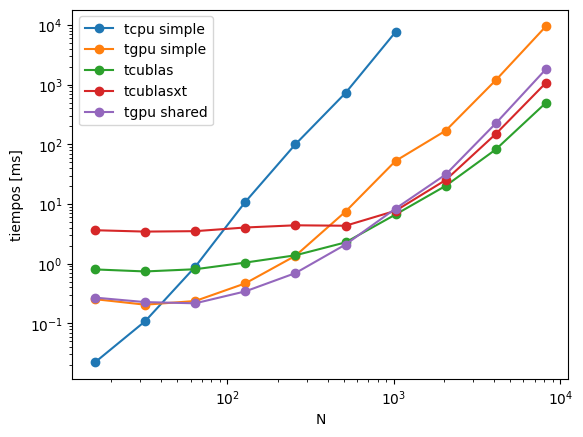

In [ ]:
#@title visualicemos los tiempos (ask chatgpt: "Plot 6 column csv file using Python, vs first column")
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('tiempos.csv', header=None)

# Split the data into five separate columns
col1 = data.iloc[:, 0]
col2 = data.iloc[:, 1]
col3 = data.iloc[:, 2]
col4 = data.iloc[:, 3]
col5 = data.iloc[:, 4]
col6 = data.iloc[:, 5]

# Plot the data
plt.loglog(col1[0:7], col2[0:7], '-o',label='tcpu simple')
plt.loglog(col1, col3,'-o', label='tgpu simple')
plt.loglog(col1, col4, '-o',label='tcublas')
plt.loglog(col1, col5,'-o' ,label='tcublasxt')
plt.loglog(col1, col6,'-o' ,label='tgpu shared')

# Add axis labels and legend
plt.xlabel('N')
plt.ylabel('tiempos [ms]')
plt.legend()

# Show the plot
plt.show()


si quieren probar N mas grandes seria conveniente no compilar con la opción de cpu, porque toma mucho tiempo para N>2048.

## Python

In [ ]:
#@title multipliquemos dos matrices de 4096x4096 con numpy (cpu)

import numpy as np
import time

# Set the sizes of the matrices
m = 4096
n = 4096
p = 4096

# Generate random matrices with the given sizes
A = np.random.rand(m, n)
B = np.random.rand(n, p)

# Compute the matrix product with a timer
start_time = time.time()
C = np.dot(A, B)
end_time = time.time()


# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")

# Print the matrices and their product
#print("A:\n", A)
#print("B:\n", B)
#print("C:\n", C)


Elapsed time:  3982.3155403137207 mseconds


notar que numpy es mucho mejor que la version naive de CPU con loops. Esto es porque numpy esta optimizado para GPU.

* usa lapack y blas por debajo
* vectoriza
* optimiza el cache
* paraleliza en CPU

In [ ]:
#@title Ahora lo hacemos en gpu con cupy

import cupy as cp
import numpy as np
import time

# Set the sizes of the matrices
m = 4096
n = 4096
p = 4096

device = cp.cuda.Device()

# Generate random matrices with the given sizes
h_A = cp.random.rand(m, n)
h_B = cp.random.rand(n, p)
h_C = cp.random.rand(m, p)

# alocate device memory before timming
A = cp.asarray(h_A)
B = cp.asarray(h_B)
C = cp.asarray(h_C)

start_time = time.time()

#copies H2D
A = cp.asarray(h_A)
B = cp.asarray(h_B)
#matrix multiplication
C = cp.dot(A, B)

device.synchronize()
end_time = time.time()

# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")


# Print the matrices and their product
#print("A:\n", A)
#print("B:\n", B)
#print("C:\n", C)


Elapsed time:  731.635332107544 mseconds


In [ ]:
#@title en gpu con cupy pero de mas bajo nivel,usando SIMPLECUDA kernel 
import cupy as cp
import numpy as np
import time

# Define matrix sizes
m = 4096
n = 4096
p = 4096
k = 4096

device = cp.cuda.Device()

# Create random matrices on the GPU
a_cpu = np.random.rand(m, n).astype(cp.float32)
b_cpu = np.random.rand(n, k).astype(cp.float32)
c_cpu = np.zeros((m, k)).astype(cp.float32)

# Define the kernel code as a string
kernel_code = """
extern "C" __global__ void matrix_multiply(float *a, float *b, float *c, int m, int n, int k) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < m && col < k) {
        float sum = 0.0f;
        for (int i = 0; i < n; i++) {
            sum += a[row * n + i] * b[i * k + col];
        }
        c[row * k + col] = sum;
    }
}
"""

# Compile the kernel code into a function
matrix_multiply = cp.RawKernel(kernel_code, 'matrix_multiply')

# Define the block and grid sizes for the kernel
block_size = (16, 16, 1)
grid_size = ((m + block_size[0] - 1) // block_size[0], (k + block_size[1] - 1) // block_size[1], 1)

a_gpu = cp.asarray(a_cpu)
b_gpu = cp.asarray(a_cpu)
c_gpu = cp.asarray(c_cpu)

start_time = time.time()
a_gpu = cp.asarray(a_cpu)
b_gpu = cp.asarray(a_cpu)

# Call the kernel function with the input matrices and sizes
matrix_multiply(grid_size, block_size, (a_gpu, b_gpu, c_gpu, m, n, k))

device.synchronize()
end_time = time.time()

# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")

# Copy the result matrix back to the CPU and print it
c_cpu = c_gpu.get()
#print(c_cpu)


Elapsed time:  603.7862300872803 mseconds


In [ ]:
#@title usando tensor flow

import cupy as cp

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


device = cp.cuda.Device()


# create two random matrices
A = tf.random.normal([4096, 4096])
B = tf.random.normal([4096, 4096])


start_time = time.time()

# multiply the matrices
C = tf.matmul(A, B)

# create a TensorFlow session
with tf.Session() as sess:
    # run the session to compute the result
    result = sess.run(C)

device.synchronize()
end_time = time.time()

# print the result
#print(result)

# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")

Elapsed time:  69.38743591308594 mseconds


In [ ]:
#@title profiling simplecuda con nvprof
!nvcc -DSIMPLECUDA -lcublas MatMul.cu; nvprof ./a.out 4096

==34011== NVPROF is profiling process 34011, command: ./a.out 4096
4096, 0, 1152.03, 0, 0,0
==34011== Profiling application: ./a.out 4096
==34011== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   96.26%  2.43205s         2  1.21602s  1.14114s  1.29091s  MatMulKernel(Matrix, Matrix, Matrix)
                    2.48%  62.618ms         4  15.654ms  14.536ms  17.802ms  [CUDA memcpy HtoD]
                    1.26%  31.921ms         2  15.960ms  15.921ms  16.000ms  [CUDA memcpy DtoH]
      API calls:   91.83%  2.52833s         6  421.39ms  14.624ms  1.30735s  cudaMemcpy
                    7.97%  219.35ms         6  36.558ms  298.11us  217.54ms  cudaMalloc
                    0.19%  5.2819ms         6  880.32us  364.73us  1.1907ms  cudaFree
                    0.00%  137.25us       101  1.3580us     134ns  60.271us  cuDeviceGetAttribute
                    0.00%  84.333us         2  42.166us  40.967us  43.366us  cudaLaunc

asi podemos ver en que funciones paso mas tiempo la corrida.

También podemos usar profiling con nvprof y cupy.

# ¿Qué hace cupy detras de la cortina?

In [ ]:
%%writefile cupyMatMul.py

import cupy as cp
import numpy as np
import time

# Set the sizes of the matrices
m = 4096
n = 4096
p = 4096

device = cp.cuda.Device()

# Generate random matrices with the given sizes
h_A = np.random.rand(m, n)
h_B = np.random.rand(n, p)
h_C = np.random.rand(m, p)

# alocate device memory before timming
A = cp.asarray(h_A)
B = cp.asarray(h_B)
C = cp.asarray(h_C)

start_time = time.time()

#copies H2D
A = cp.asarray(h_A)
B = cp.asarray(h_B)
#matrix multiplication
C = cp.dot(A, B)

device.synchronize()
end_time = time.time()

# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")



Overwriting cupyMatMul.py


In [ ]:
!cat cupyMatMul.py


import cupy as cp
import numpy as np
import time

# Set the sizes of the matrices
m = 4096
n = 4096
p = 4096

device = cp.cuda.Device()

# Generate random matrices with the given sizes
h_A = np.random.rand(m, n)
h_B = np.random.rand(n, p)
h_C = np.random.rand(m, p)

# alocate device memory before timming
A = cp.asarray(h_A)
B = cp.asarray(h_B)
C = cp.asarray(h_C)

start_time = time.time()

#copies H2D
A = cp.asarray(h_A)
B = cp.asarray(h_B)
#matrix multiplication
C = cp.dot(A, B)

device.synchronize()
end_time = time.time()

# Print the elapsed time
print("Elapsed time: ", (end_time - start_time)*1000, "mseconds")



In [ ]:
!nvprof --openacc-profiling off python cupyMatMul.py

==2581== NVPROF is profiling process 2581, command: python3 cupyMatMul.py
Elapsed time:  1426.6047477722168 mseconds
==2581== Profiling application: python3 cupyMatMul.py
==2581== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   92.75%  694.39ms         1  694.39ms  694.39ms  694.39ms  volta_dgemm_128x64_nn
                    7.25%  54.283ms         5  10.857ms  10.849ms  10.870ms  [CUDA memcpy HtoD]
      API calls:   39.52%  694.37ms         5  138.87ms  1.1270us  694.35ms  cudaDeviceSynchronize
                   38.42%  674.94ms         5  134.99ms  27.199us  528.27ms  cudaFree
                   15.77%  277.03ms         7  39.576ms  4.2060us  275.09ms  cudaMalloc
                    6.21%  109.16ms         2  54.579ms  54.404ms  54.754ms  cudaHostAlloc
                    0.03%  509.52us       768     663ns     140ns  252.93us  cuGetProcAddress
                    0.02%  405.66us       297  1.3650us     132ns  

In [ ]:
#@title profiling cublas con nvprof
!nvcc -DCUBLAS -lcublas MatMul.cu; nvprof ./a.out 4096

==34379== NVPROF is profiling process 34379, command: ./a.out 4096
4096, 0, 0, 115.04, 0,0
==34379== Profiling application: ./a.out 4096
==34379== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   44.26%  94.984ms         2  47.492ms  47.489ms  47.495ms  volta_sgemm_128x64_nn
                   41.69%  89.475ms         6  14.913ms  14.225ms  17.675ms  [CUDA memcpy HtoD]
                   14.05%  30.154ms         2  15.077ms  15.057ms  15.097ms  [CUDA memcpy DtoH]
      API calls:   62.33%  718.47ms        15  47.898ms  1.0870us  565.75ms  cudaFree
                   18.88%  217.66ms         8  27.207ms  14.468ms  63.008ms  cudaMemcpy
                   18.70%  215.49ms        12  17.958ms  4.7610us  213.98ms  cudaMalloc
                    0.04%  420.65us       297  1.4160us     124ns  70.593us  cuDeviceGetAttribute
                    0.02%  188.88us       768     245ns     138ns  1.4650us  cuGetProcAddress
        